In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Build 45k Dataset

In [26]:
new_dataset = pd.read_csv('/share/pi/ogevaert/zhang/body_classifier/image_path_results_final_2.csv')
old_dataset = pd.read_csv('/share/pi/ogevaert/zhang/body_classifier/image_path_results_final.csv')

# for entry in in old_dataset, if the body location does not match new_dataset, change the body location to new dataset
for index, row in old_dataset.iterrows():
    if row['body_label'] != new_dataset.at[index, 'body_label']:
        if new_dataset.at[index, 'body_label'] != 'closeup':
            old_dataset.at[index, 'body_label'] = new_dataset.at[index, 'body_label']

# save the new dataset
old_dataset.to_csv('/share/pi/ogevaert/zhang/body_classifier/image_path_results_no_closeup.csv', index=False)

# remove the closeup images from the no_closeup dataset
no_closeup = pd.read_csv('/share/pi/ogevaert/zhang/body_classifier/image_path_results_no_closeup.csv')
no_closeup = no_closeup[no_closeup['body_label'] != 'closeup']
no_closeup.to_csv('/share/pi/ogevaert/zhang/body_classifier/image_path_results_no_closeup.csv', index=False)

# remove the non-skin images from the no_closeup dataset
no_closeup = pd.read_csv('/share/pi/ogevaert/zhang/body_classifier/image_path_results_no_closeup.csv')
no_closeup = no_closeup[no_closeup['body_label'] != 'non-skin']
no_closeup.to_csv('/share/pi/ogevaert/zhang/body_classifier/image_path_results_no_closeup.csv', index=False)

In [6]:
new_dataset = pd.read_csv('/share/pi/ogevaert/zhang/body_classifier/image_path_results_final_2.csv')
old_dataset = pd.read_csv('/share/pi/ogevaert/zhang/body_classifier/image_path_results_final.csv')
no_closeup = pd.read_csv('/share/pi/ogevaert/zhang/body_classifier/image_path_results_no_closeup.csv')
# print the number of closeup images in each dataset
print('new dataset closeup: ', len(new_dataset[new_dataset['body_label'] == 'closeup']))
print('old dataset closeup: ', len(old_dataset[old_dataset['body_label'] == 'closeup']))
print('no closeup dataset closeup: ', len(no_closeup[no_closeup['body_label'] == 'closeup']))

new dataset closeup:  449
old dataset closeup:  78
no closeup dataset closeup:  0


# Build 16k Dataset

In [27]:
csv_path = '/home/serena2z/cleaned.csv'
df = pd.read_csv(csv_path)
# get all the images with included true
images = []
for index, row in df.iterrows():
    if row['include'] == True:
        images.append(row['image_file'])
no_closeup = pd.read_csv('/share/pi/ogevaert/zhang/body_classifier/image_path_results_no_closeup.csv')

# remove the images that are not included in the dataset
for index, row in no_closeup.iterrows():
    if row['image_file'] not in images:
        no_closeup.drop(index, inplace=True)

# save the new dataset as a csv file
no_closeup.to_csv('/share/pi/ogevaert/zhang/body_classifier/image_path_results_16k.csv', index=False)

# Validate 16k Dataset

In [23]:
import os
import shutil
import xlsxwriter
import io
from PIL import Image
import pandas as pd
import xlsxwriter.utility

label_dict = {"face": 0, "scalp": 1, "ear": 2, "neck": 3, "shoulders": 4, "arms_upper": 5, "arms_lower": 6, "hands": 7, "chest": 8, "abdomen": 9, "back_upper": 10, "back_lower": 11, "hips_and_glutes": 12, "genital_and_perianal": 13, "legs_upper": 14, "legs_lower": 15, "feet": 16, "closeup": 17, "dermoscope": 18, "non-skin": 19 }
inverse_label_dict = {v: k for k, v in label_dict.items()}


def get_resized_image_data(file_path, bound_width_height = (250, 250)):
    # get the image and resize it
    im = Image.open(file_path)
    im.thumbnail(bound_width_height, Image.ANTIALIAS)  # ANTIALIAS is important if shrinking

    # stuff the image data into a bytestream that excel can read
    im_bytes = io.BytesIO()
    im.save(im_bytes, format='PNG')
    return im_bytes

def create_excel(name, df, folder):
    workbook = xlsxwriter.Workbook(name)
    worksheet = workbook.add_worksheet()

    print('in create_excel')
    
    images = []
    #df = pd.read_csv(csv)
    df = df.reset_index(drop=True)
    for index, row in df.iterrows():
        images.append(folder + row['image_file'])
        
    image_row = 0
    image_col = 3
    for image in images:
        try:
            cell = xlsxwriter.utility.xl_rowcol_to_cell(image_row, image_col)
            # insert the name of the mask file into column 1
            worksheet.write(image_row, 1, df['image_file'][image_row])
            # insert the label of the image file into column 2
            worksheet.write(image_row, 2, df['body_label'][image_row])
            #print('trying to get resized image data')

            # get the image data
            image = get_resized_image_data(image)
            #print('got resized image data')

            worksheet.insert_image(cell, df['image_file'][image_row], {'image_data': image})

        # resize the image and insert it into the excel file
        #worksheet.insert_image(image_row, image_col, image, {'x_scale': 0.1, 'y_scale': 0.1, 
                            # 'x_offset': 0, 'y_offset': 0,
                            # 'positioning': 1})
        # resize the column and row width to fit the image

            worksheet.set_column(image_col, image_col, 250)
            worksheet.set_row(image_row, 250)

            image_row += 1
        except:
            # if the image is not found, remove it from the csv file
            print('image not found: ', image)
            continue
        
    # save the excel file
    workbook.close()

In [25]:
csv_16k = '/share/pi/ogevaert/zhang/body_classifier/image_path_results_16k.csv'
df_16k = pd.read_csv(csv_16k)
df_16k = df_16k[:1000]
dir = '/share/pi/ogevaert/sadee/skin/clinical/som-dermatology-photos-2020/'
create_excel('16k.xlsx', df_16k, dir)

in create_excel


/tmp/ipykernel_1821203/2666296453.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im.thumbnail(bound_width_height, Image.ANTIALIAS)  # ANTIALIAS is important if shrinking


# Train Test Split

In [2]:
csv_16k = '/share/pi/ogevaert/zhang/body_classifier/image_path_results_16k.csv'
csv_45k = '/share/pi/ogevaert/zhang/body_classifier/image_path_results_no_closeup.csv'
df_16k = pd.read_csv(csv_16k)
df_45k = pd.read_csv(csv_45k)

In [7]:
label_dict = {"face": 0, "scalp": 1, "ear": 2, "neck": 3, "shoulders": 4, "arms_upper": 5, "arms_lower": 6, "hands": 7, "chest": 8, "abdomen": 9, "back_upper": 10, "back_lower": 11, "hips_and_glutes": 12, "genital_and_perianal": 13, "legs_upper": 14, "legs_lower": 15, "feet": 16, "dermoscope": 17}
# print the number of images in each body location
for key in label_dict:
    print(key, len(df_16k[df_16k['body_label'] == key]))
    # create a bar plot of the number of images in each body location
for key in label_dict:
    print(key, len(df_45k[df_45k['body_label'] == key]))
    # create a bar plot of the number of images in each body location

        

face 3004
scalp 738
ear 536
neck 595
shoulders 714
arms_upper 840
arms_lower 777
hands 649
chest 1029
abdomen 567
back_upper 1717
back_lower 290
hips_and_glutes 194
genital_and_perianal 149
legs_upper 737
legs_lower 1219
feet 430
dermoscope 176
face 8195
scalp 2563
ear 1590
neck 1798
shoulders 1920
arms_upper 3014
arms_lower 2324
hands 2171
chest 3151
abdomen 2059
back_upper 5609
back_lower 1041
hips_and_glutes 616
genital_and_perianal 402
legs_upper 2198
legs_lower 4361
feet 1430
dermoscope 392


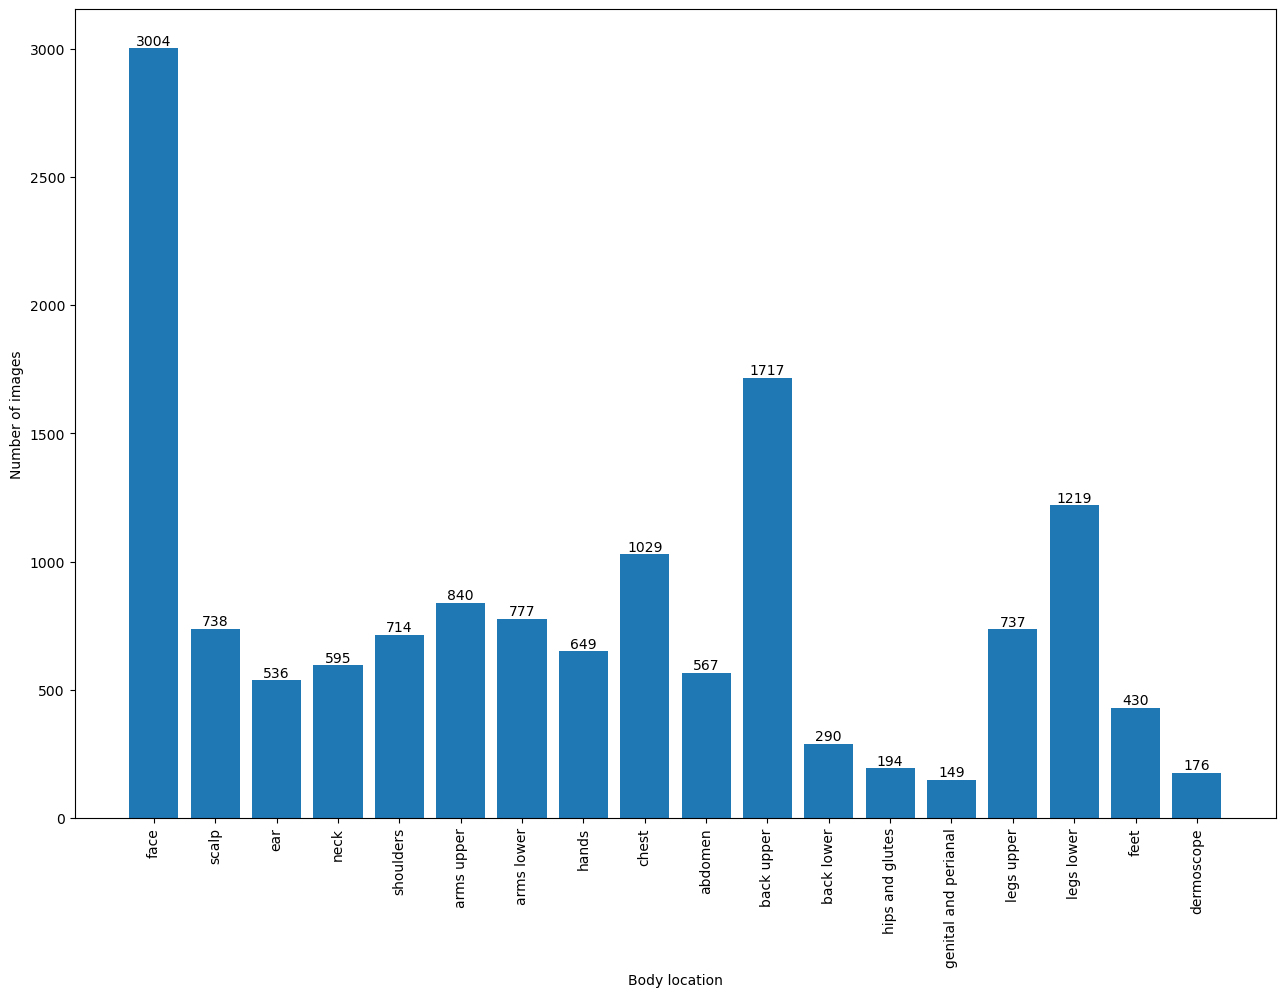

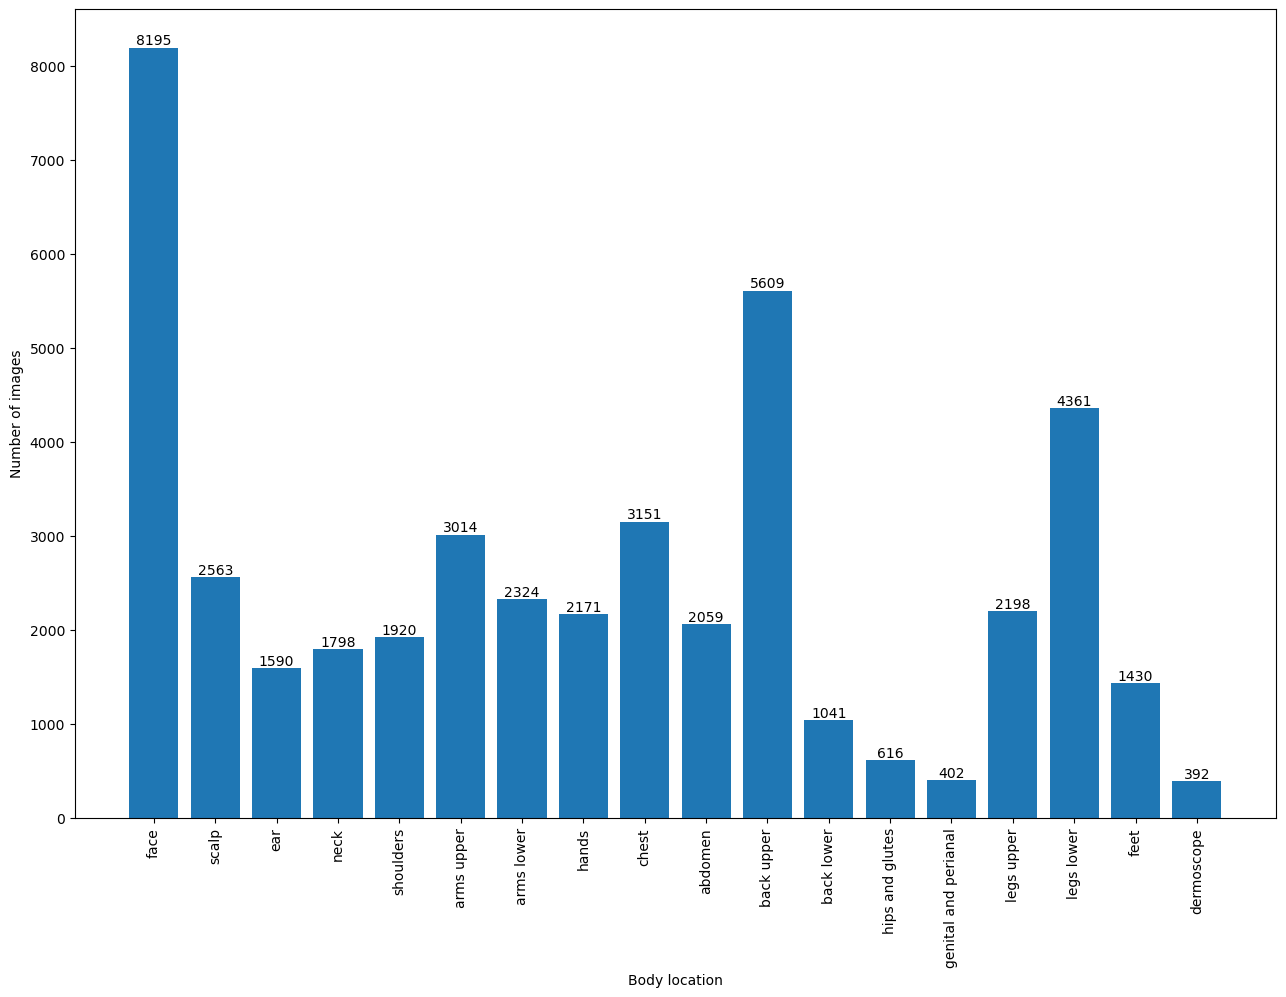

<Figure size 640x480 with 0 Axes>

In [15]:

def draw_bar(label_dict, df, name):
    new_label_dict = {"face": 0, "scalp": 1, "ear": 2, "neck": 3, "shoulders": 4, "arms upper": 5, "arms lower": 6, "hands": 7, "chest": 8, "abdomen": 9, "back upper": 10, "back lower": 11, "hips and glutes": 12, "genital and perianal": 13, "legs upper": 14, "legs lower": 15, "feet": 16, "dermoscope": 17}
    # create a bar plot of the number of images in each body location
    plt.bar(new_label_dict.keys(), [len(df[df['body_label'] == key]) for key in label_dict.keys()])
    plt.xticks(rotation=90)
    plt.ylabel('Number of images')
    plt.xlabel('Body location')
    # write the number of images in each body location on top of the bar
    for index, value in enumerate([len(df[df['body_label'] == key]) for key in label_dict.keys()]):
        plt.text(index, value, str(value), ha='center', va='bottom')
    # increase bar size
    plt.gcf().set_size_inches(15.5, 10.5)
    plt.show()
    plt.savefig(name + '_barplot.png')

draw_bar(label_dict, df_16k, '16k')
draw_bar(label_dict, df_45k, '45k')

In [30]:

train_df, test_df = train_test_split(df_16k, test_size=0.2, random_state=42, stratify=df_16k['body_label'])
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['body_label'])

print(len(train_df), len(test_df), len(val_df))
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df.to_csv('/share/pi/ogevaert/zhang/body_classifier/body_train_16k.csv', index=False)
test_df.to_csv('/share/pi/ogevaert/zhang/body_classifier/body_test_16k.csv', index=False)
val_df.to_csv('/share/pi/ogevaert/zhang/body_classifier/body_val_16k.csv', index=False)

11488 1436 1437


In [31]:

train_df, test_df = train_test_split(df_45k, test_size=0.2, random_state=42, stratify=df_45k['body_label'])
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['body_label'])

print(len(train_df), len(test_df), len(val_df))
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df.to_csv('/share/pi/ogevaert/zhang/body_classifier/body_train_45k.csv', index=False)
test_df.to_csv('/share/pi/ogevaert/zhang/body_classifier/body_test_45k.csv', index=False)
val_df.to_csv('/share/pi/ogevaert/zhang/body_classifier/body_val_45k.csv', index=False)

35867 4483 4484


# Get More Genital & Perianal Pictures

In [ ]:
import os
import shutil
import pandas as pd

file = '/share/pi/ogevaert/zhang/body_classifier/image_path_results_no_closeup.csv'
folder = '/share/pi/ogevaert/sadee/skin/clinical/som-dermatology-photos-2020/'

df = pd.read_csv(file)
# if the image is not in the csv, create a new folder and copy the image to the new folder
for file in os.listdir(folder):
    #print('file: ', file)
    if file not in df['image_file'].values and file.endswith('.JPG'):
        print('copying file: ', file)
        shutil.copy('/share/pi/ogevaert/sadee/skin/clinical/som-dermatology-photos-2020/' + file, '/share/pi/ogevaert/zhang/body_classifier/70k/' + file.split('/')[0])    

In [ ]:
import os
import pandas as pd
import random

file = '/share/pi/ogevaert/zhang/body_classifier/image_path_results_no_closeup.csv'
g_and_p = '/share/pi/ogevaert/zhang/body_classifier/genital_and_perianal/'
_derm = '/share/pi/ogevaert/sadee/skin/isic/images'

df = pd.read_csv(file)
df['image_file'] = '/share/pi/ogevaert/sadee/skin/clinical/som-dermatology-photos-2020/' + df['image_file']

print(len(df))
#add the images from the genital and perianal folder to the csv
for file in os.listdir(g_and_p):
    if file.endswith('.JPG'):
        df = df.append({'image_file': '/share/pi/ogevaert/sadee/skin/clinical/som-dermatology-photos-2020/'+ file, 'body_label': 'genital_and_perianal'}, ignore_index=True)

# add 100 random dermoscope images to the csv
for i in range(100):
    file = random.choice(os.listdir(_derm))
    df = df.append({'image_file': '/share/pi/ogevaert/sadee/skin/isic/images/' + file, 'body_label': 'dermoscope'}, ignore_index=True)

print(len(df))

In [2]:
# save the new csv
df.to_csv('/share/pi/ogevaert/zhang/body_classifier/image_path_results_no_closeup_0612.csv', index=False)

In [25]:
import matplotlib.pyplot as plt

csv = '/share/pi/ogevaert/zhang/body_classifier/image_path_results_no_closeup_0612.csv'
df_45k = pd.read_csv(csv)

# map the body labels to the new labels
label_dict = {"face": 0, "scalp": 1, "ear": 0, "neck": 2, "shoulders": 3, "arms_upper": 4, "arms_lower": 4, "hands": 5, "chest": 6, "abdomen": 6, "back_upper": 7, "back_lower": 7, "hips_and_glutes": 8, "genital_and_perianal": 9, "legs_upper": 8, "legs_lower": 8, "feet": 10, "dermoscope": 11}
new_label_dict = {"face": 0, "scalp": 1, "neck": 2, "shoulders": 3, "arms": 4, "hands": 5, "chest and abdomen": 6, "back": 7, "legs": 8, "genital and perianal": 9, "feet": 10, "dermoscope": 11}
mapping = {"face": "face", "scalp": "scalp", "ear": "face", "neck": "neck", "shoulders": "shoulders", "arms_upper": "arms", "arms_lower": "arms", "hands": "hands", "chest": "chest and abdomen", "abdomen": "chest and abdomen", "back_upper": "back", "back_lower": "back", "hips_and_glutes": "legs", "genital_and_perianal": "genital and perianal", "legs_upper": "legs", "legs_lower": "legs", "feet": "feet", "dermoscope": "dermoscope"}
# print the number of images in each body location using a for loop

df_45k['body_label'] = df_45k['body_label'].map(mapping)
# print the number of images in each body location
print([len(df_45k[df_45k['body_label'] == key]) for key in new_label_dict.keys()])

[9785, 2563, 1798, 1920, 5338, 2171, 5210, 6650, 7175, 501, 1430, 492]


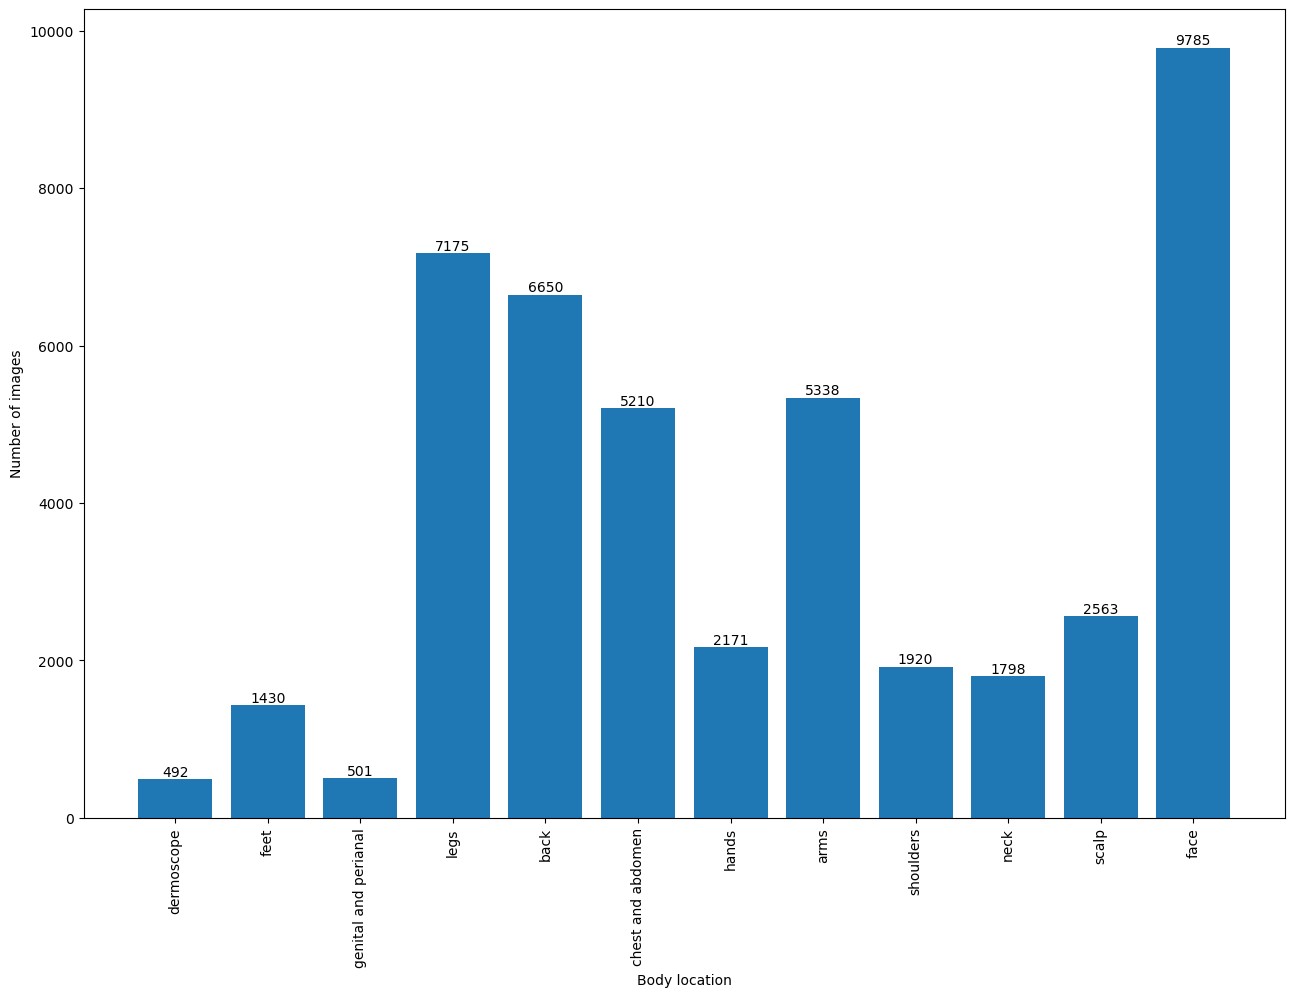

<Figure size 640x480 with 0 Axes>

In [27]:
def draw_bar(label_dict, df, name, new_label_dict):
    # create a bar plot of the number of images in each body location
    plt.bar(new_label_dict.keys(), [len(df[df['body_label'] == key]) for key in new_label_dict.keys()])
    plt.xticks(rotation=90)
    plt.ylabel('Number of images')
    plt.xlabel('Body location')
    # write the number of images in each body location on top of the bar
    for index, value in enumerate([len(df[df['body_label'] == key]) for key in new_label_dict.keys()]):
        plt.text(index, value, str(value), ha='center', va='bottom')
    # increase bar size
    plt.gcf().set_size_inches(15.5, 10.5)
    # order x axis by number of images from most to least
    plt.gca().invert_xaxis()
    plt.show()
    plt.savefig(name + '_barplot.png')

draw_bar(label_dict, df_45k, '45k_combined', new_label_dict)


In [29]:

train_df, test_df = train_test_split(df_45k, test_size=0.2, random_state=42, stratify=df_45k['body_label'])
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['body_label'])

print(len(train_df), len(test_df), len(val_df))
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df.to_csv('/share/pi/ogevaert/zhang/body_classifier/body_train_45k_combined.csv', index=False)
test_df.to_csv('/share/pi/ogevaert/zhang/body_classifier/body_test_45k_combined.csv', index=False)
val_df.to_csv('/share/pi/ogevaert/zhang/body_classifier/body_val_45k_combined.csv', index=False)

36026 4503 4504


# Adding Fitz

In [9]:
import os
import pandas as pd
import random

file = '/share/pi/ogevaert/zhang/body_classifier/image_path_results_no_closeup_0612.csv'
df_45k = pd.read_csv(file)

# map the body labels to the new labels
label_dict = {"face": 0, "scalp": 1, "ear": 0, "neck": 2, "shoulders": 3, "arms_upper": 4, "arms_lower": 4, "hands": 5, "chest": 6, "abdomen": 6, "back_upper": 7, "back_lower": 7, "hips_and_glutes": 8, "genital_and_perianal": 9, "legs_upper": 8, "legs_lower": 8, "feet": 10, "dermoscope": 11}
new_label_dict = {"face": 0, "scalp": 1, "neck": 2, "shoulders": 3, "arms": 4, "hands": 5, "chest and abdomen": 6, "back": 7, "legs": 8, "genital and perianal": 9, "feet": 10, "dermoscope": 11}
mapping = {"face": "face", "scalp": "scalp", "ear": "face", "neck": "neck", "shoulders": "shoulders", "arms_upper": "arms", "arms_lower": "arms", "hands": "hands", "chest": "chest and abdomen", "abdomen": "chest and abdomen", "back_upper": "back", "back_lower": "back", "hips_and_glutes": "legs", "genital_and_perianal": "genital and perianal", "legs_upper": "legs", "legs_lower": "legs", "feet": "feet", "dermoscope": "dermoscope"}
# print the number of images in each body location using a for loop

df_45k['body_label'] = df_45k['body_label'].map(mapping)
# print the number of images in each body location
print([len(df_45k[df_45k['body_label'] == key]) for key in new_label_dict.keys()])

# save the new dataframe
df_45k.to_csv('/share/pi/ogevaert/zhang/body_classifier/image_path_results_no_closeup_combined.csv', index=False)

[9785, 2563, 1798, 1920, 5338, 2171, 5210, 6650, 7175, 501, 1430, 492]


In [10]:
file_comb = '/share/pi/ogevaert/zhang/body_classifier/fitz17k_labeled_combined.csv'
df_comb = pd.read_csv(file_comb)
# count the number of images in each body location
print([len(df_comb[df_comb['body_label'] == key]) for key in new_label_dict.keys()])

[200, 100, 103, 0, 228, 102, 207, 204, 265, 131, 101, 0]


In [11]:
csv = '/share/pi/ogevaert/zhang/body_classifier/image_path_results_no_closeup_combined.csv'
df = pd.read_csv(csv)

file_rename = '/share/pi/ogevaert/zhang/body_classifier/shoulders_clin_relabeled.csv'
df_rename = pd.read_csv(file_rename)
df_rename['file_name'] = '/share/pi/ogevaert/sadee/skin/clinical/som-dermatology-photos-2020/' + df_rename['file_name'] 

# for each image in the dataframe, check if the image is in the renamed dataframe
# if it is, rename the image in the dataframe
for index, row in df.iterrows():
    if row['image_file'] in df_rename['file_name'].values:
        # change the body label to the new label
        df.at[index, 'body_label'] = df_rename[df_rename['file_name'] == row['image_file']]['body_label'].values[0]

fitz = '/share/pi/ogevaert/zhang/body_classifier/fitz17k_labeled_combined.csv'
df_fitz = pd.read_csv(fitz)
df_fitz['file_name'] = '/share/pi/ogevaert/sadee/skin/fitz17k/images/' + df_fitz['file_name']
# add all the images from the fitz dataframe to the dataframe
for i in range(len(df_fitz)):
    df = df.append({'image_file': df_fitz['file_name'][i], 'body_label': df_fitz['body_label'][i]}, ignore_index=True)

# save the new dataframe
df.to_csv('/share/pi/ogevaert/zhang/body_classifier/image_path_results_no_closeup_combined_0622.csv', index=False)

/tmp/ipykernel_1676865/1314273283.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'image_file': df_fitz['file_name'][i], 'body_label': df_fitz['body_label'][i]}, ignore_index=True)
/tmp/ipykernel_1676865/1314273283.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'image_file': df_fitz['file_name'][i], 'body_label': df_fitz['body_label'][i]}, ignore_index=True)
/tmp/ipykernel_1676865/1314273283.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'image_file': df_fitz['file_name'][i], 'body_label': df_fitz['body_label'][i]}, ignore_index=True)
/tmp/ipykernel_1676865/1314273283.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

# Train/Test Split

In [24]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('/share/pi/ogevaert/zhang/body_classifier/image_path_results_no_closeup_combined_0622.csv')

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['body_label'])
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['body_label'])

print(len(train_df), len(test_df), len(val_df))
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df.to_csv('/share/pi/ogevaert/zhang/body_classifier/body_train_45k_combined_fitz.csv', index=False)
test_df.to_csv('/share/pi/ogevaert/zhang/body_classifier/body_test_45k_combined_fitz.csv', index=False)
val_df.to_csv('/share/pi/ogevaert/zhang/body_classifier/body_val_45k_combined_fitz.csv', index=False)

37337 4667 4668


In [2]:
import os
import cv2
import numpy as np

folder = '/share/pi/ogevaert/zhang/datasets/DDI/all_DDI_masks'
# print the unique image sizes in the folder
sizes = []
for file in os.listdir(folder):
    if file.endswith('.png'):
        img = cv2.imread(os.path.join(folder, file))
        sizes.append(img.shape)
print(set(sizes))

# %%
# DEMO
batchSize=32
numWorkers=8

def collate_folders(folder_paths):
    for folder in folder_paths:
        # get the path of all the folders that starts with "predicted"
        sub_folder_paths = glob.glob(folder + '/predicted*')
        # get the file called all_images.txt
        all_images_file = glob.glob(folder + '/all_images.txt')
        print(all_images_file)
        # build the dataloader for each folder
        for sub_folder in sub_folder_paths:
            # read all_images_file into a dataframe
            image_df = pd.read_fwf(all_images_file[0], header=0)
            image_df['image_path'] = image_df['image_path'].str.split('/').str[-1]
            image_df['image_path'] = sub_folder + '/' + image_df['image_path']
            image_df['image_path'] = image_df['image_path'].str.replace('.jpg', '.png')

            dataset = CustomImageDataset(image_df, img_path='image_path')
            dataloader = DataLoader(dataset, batch_size=batchSize, shuffle=False, num_workers=numWorkers)

            # get the name of the sub_directory
            sub_folder_name = sub_folder.split('/')[-1]
            run(dataloader, save_dir=folder + '/' + sub_folder_name + "_stats.csv")

# %%

if __name__ == "__main__":
    folder_paths = ["/share/pi/ogevaert/sadee/skin/fitz17k", "/share/pi/ogevaert/sadee/skin/esteva", "/share/pi/ogevaert/sadee/skin/DermNet", "/share/pi/ogevaert/sadee/skin/DDI", "/share/pi/ogevaert/sadee/skin/clinical"]
    collate_folders(folder_paths)


{(447, 549, 3), (708, 540, 3), (640, 772, 3), (609, 445, 3), (886, 1250, 3), (1429, 1041, 3), (685, 512, 3), (864, 985, 3), (680, 500, 3), (385, 305, 3), (677, 437, 3), (353, 497, 3), (579, 749, 3), (1246, 928, 3), (678, 921, 3), (297, 495, 3), (357, 294, 3), (449, 383, 3), (867, 982, 3), (699, 519, 3), (688, 500, 3), (1226, 940, 3), (638, 467, 3), (422, 391, 3), (399, 393, 3), (806, 998, 3), (458, 323, 3), (1379, 1007, 3), (686, 501, 3), (703, 520, 3), (334, 336, 3), (1303, 1046, 3), (455, 299, 3), (1008, 756, 3), (920, 1013, 3), (637, 467, 3), (243, 245, 3), (702, 525, 3), (697, 524, 3), (798, 924, 3), (707, 538, 3), (748, 1228, 3), (703, 521, 3), (426, 365, 3), (364, 265, 3), (380, 243, 3), (691, 521, 3), (358, 463, 3), (365, 682, 3), (681, 464, 3), (643, 1283, 3), (694, 518, 3), (1066, 447, 3), (630, 799, 3), (981, 939, 3), (687, 501, 3), (690, 923, 3), (376, 468, 3), (637, 470, 3), (434, 510, 3), (693, 517, 3), (218, 155, 3), (177, 290, 3), (1391, 1017, 3), (1401, 1031, 3), (645, 